In [2]:
import torch
import tenseal as ts
import pandas as pd
import random
from time import time

# those are optional and are not necessary for training
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Import library
import pandas  as pd #Data manipulation
import numpy as np #Data manipulation
import matplotlib.pyplot as plt # Visualization
import seaborn as sns #Visualization
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['font.size'] =14
plt.rcParams['font.weight']= 'bold'
plt.style.use('seaborn-whitegrid')

C:\Users\hamma\AppData\Local\Temp\ipykernel_1400\2082293316.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


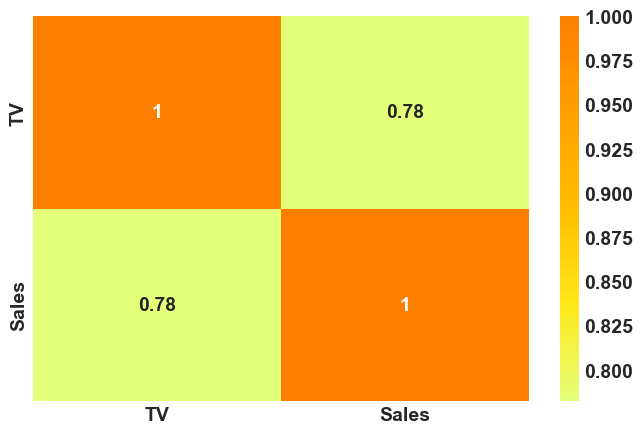

In [4]:
df = pd.read_csv("./advertising.csv")
# correlation plot
corr = df.corr()
sns.heatmap(corr, cmap = 'Wistia', annot= True);

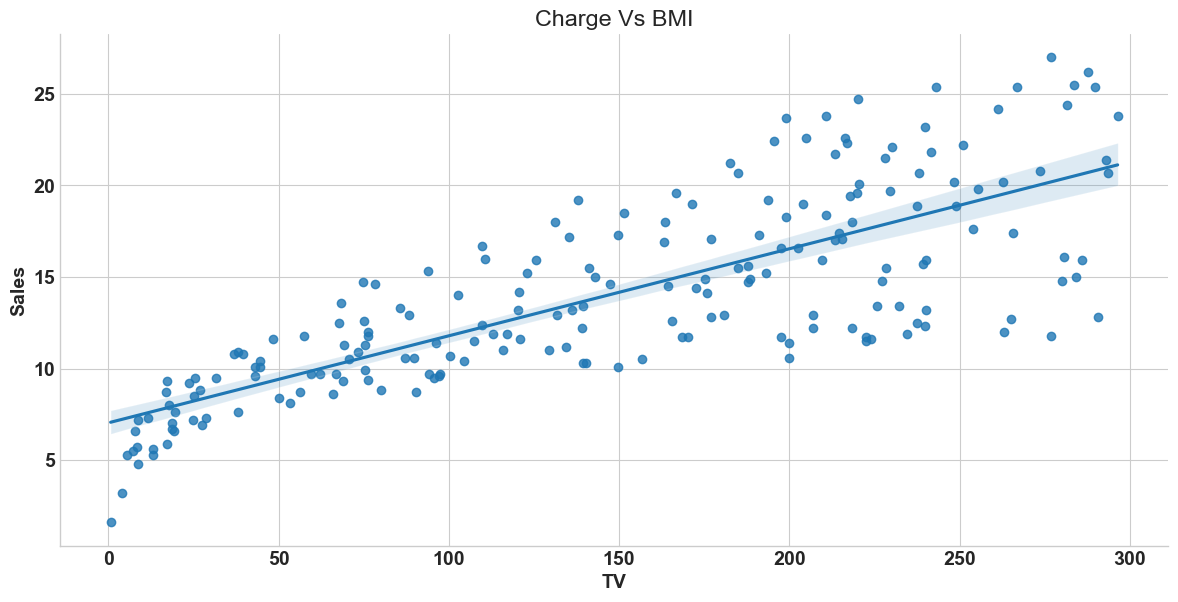

In [5]:
""" for our visualization purpose will fit line using seaborn library only for bmi as independent variable
and charges as dependent variable"""

sns.lmplot(x='TV',y='Sales',data=df,aspect=2,height=6)
plt.xlabel('TV')
plt.ylabel('Sales')
plt.title('Charge Vs BMI');

In [6]:
data = pd.read_csv("./advertising.csv")
# drop rows with missing values
# data = data.dropna()
# # drop some features
# data = data.drop(columns=["education", "currentSmoker", "BPMeds", "diabetes", "diaBP", "BMI"])
# # balance data
# grouped = data.groupby('TenYearCHD')
# data = grouped.apply(lambda x: x.sample(grouped.size().min(), random_state=73).reset_index(drop=True))
# # extract labels
y = data["Sales"].values
# data = data.drop("TenYearCHD", 'columns')
# # standardize data
# data = (data - data.mean()) / data.std()
#
# for i in data.columns:
#     if i != 'age':
#         data = data.drop(columns=[i])
x = data["TV"].values
# split_train_test(x, y)

In [7]:
def split_train_test(x, y, test_ratio=0.3):
    idxs = [i for i in range(len(x))]
    random.shuffle(idxs)
    # delimiter between test and train data
    delim = int(len(x) * test_ratio)
    test_idxs, train_idxs = idxs[:delim], idxs[delim:]
    return x[train_idxs], y[train_idxs], x[test_idxs], y[test_idxs]

In [8]:
x_train, y_train, x_test, y_test = split_train_test(x, y)

In [9]:
n_features = x_train.shape[0]

In [10]:
sum_y=0
for i in range(y_train.shape[0]):
    sum_y += y_train[i]
sum_x=0
for i in range(x_train.shape[0]):
    sum_x += x_train[i]
sum_x2=0
for xi in x_train:
    sum_x2 += xi*xi
sum_x_2=sum_x **2
sum_x_y=0
for xi,yi in zip(x_train,y_train):
    sum_x_y += xi*yi


In [11]:
a1_reel = sum_y*sum_x2 - sum_x*sum_x_y
a2_reel = n_features * sum_x2 - sum_x_2
b1_reel = n_features * sum_x_y - sum_x*sum_y
b2_reel = n_features * sum_x2 - sum_x2

In [12]:
a = a1_reel/a2_reel
b = b1_reel/b2_reel

In [13]:
a

7.202476342371459

In [14]:
b

0.011622097779326285

In [15]:
y_pred_1 = [ a + b * xi for xi in x_train]

In [16]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_train, y_pred_1)

In [17]:
mse

42.34348879330624

In [18]:
a = a1_reel/a2_reel
b = b1_reel/b2_reel

y_pred_test = [ a + b * xi for xi in x_test]

In [19]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred_test)
mse

54.85092658441088

In [20]:
from ckks.ckks_decryptor import CKKSDecryptor
from ckks.ckks_encoder import CKKSEncoder
from ckks.ckks_encryptor import CKKSEncryptor
from ckks.ckks_evaluator import CKKSEvaluator
from ckks.ckks_key_generator import CKKSKeyGenerator
from ckks.ckks_parameters import CKKSParameters

In [21]:
poly_degree = 2  ##2**(x.bit_length()+1)
ciph_modulus = 1 << 600
big_modulus = 1 << 1200
scaling_factor = 1 << 30
params = CKKSParameters(poly_degree=poly_degree,
                        ciph_modulus=ciph_modulus,
                        big_modulus=big_modulus,
                        scaling_factor=scaling_factor)
key_generator = CKKSKeyGenerator(params)
public_key = key_generator.public_key
secret_key = key_generator.secret_key
relin_key = key_generator.relin_key
encoder = CKKSEncoder(params)
encryptor = CKKSEncryptor(params, public_key, secret_key)
decryptor = CKKSDecryptor(params, secret_key)
evaluator = CKKSEvaluator(params)

In [22]:
t_start = time()
enc_x_train_me = [encryptor.encrypt(encoder.encode([x,], scaling_factor)) for x in x_train]
enc_y_train_me= [encryptor.encrypt(encoder.encode([y,], scaling_factor)) for y in y_train]
t_end = time()
print(f"Encryption of the training_set took {int(t_end - t_start)} seconds")

Encryption of the training_set took 1 seconds


In [25]:
sum_enc_y=enc_y_train_me[0]
for i in range(1,x_train.shape[0]):
    sum_enc_y = evaluator.add(sum_enc_y,enc_y_train_me[i])


sum_enc_x=enc_x_train_me[0]
for i in range(1,x_train.shape[0]):
    sum_enc_x = evaluator.add(sum_enc_x,enc_x_train_me[i])


sum_enc_x2=evaluator.multiply(enc_x_train_me[0],enc_x_train_me[0],relin_key)
for i in range(1,x_train.shape[0]):
    sum_enc_x2 = evaluator.add(sum_enc_x2,evaluator.multiply(enc_x_train_me[i],enc_x_train_me[i],relin_key))


sum_enc_x_2=evaluator.multiply(sum_enc_x,sum_enc_x,relin_key)


sum_enc_x_y = evaluator.multiply(enc_x_train_me[0],enc_y_train_me[0],relin_key)
for i in range(1,x_train.shape[0]):
    sum_enc_x_y = evaluator.add(sum_enc_x_y,evaluator.multiply(enc_x_train_me[i],enc_y_train_me[i],relin_key))


In [26]:
print(encoder.decode(decryptor.decrypt(sum_enc_x))[0].real,sum_x)
print(encoder.decode(decryptor.decrypt(sum_enc_y))[0].real,sum_y)
print(encoder.decode(decryptor.decrypt(sum_enc_x2))[0].real,sum_x2)
print(encoder.decode(decryptor.decrypt(sum_enc_x_y))[0].real,sum_x_y)

20283.899999994785 20283.9
1922.9999999906868 1923.0000000000005
3949500.649994821 3949500.6500000013
324187.47000181425 324187.46999999986


In [27]:
sum_enc_x2 = evaluator.rescale(sum_enc_x2,scaling_factor)
sum_enc_x_2 = evaluator.rescale(sum_enc_x_2,scaling_factor)
sum_enc_x_y = evaluator.rescale(sum_enc_x_y,scaling_factor)


In [28]:
n_features=encryptor.encrypt(encoder.encode([n_features,], scaling_factor))


y = a + b * x
a = a1 / a2
b = b1 / b2

In [29]:
a1 = evaluator.subtract(
    evaluator.rescale(evaluator.multiply(sum_enc_y,sum_enc_x2,relin_key),scaling_factor) ,
    evaluator.rescale(evaluator.multiply(sum_enc_x,sum_enc_x_y,relin_key),scaling_factor)
)

a2 = evaluator.subtract(
    evaluator.rescale(evaluator.multiply(n_features,sum_enc_x2,relin_key),scaling_factor),
    sum_enc_x_2
)


b1 = evaluator.subtract(
    evaluator.rescale(evaluator.multiply(n_features,sum_enc_x_y,relin_key),scaling_factor),
    evaluator.rescale(evaluator.multiply(sum_enc_x,sum_enc_y,relin_key),scaling_factor)
)

b2 = evaluator.subtract(
    evaluator.rescale(evaluator.multiply(n_features,sum_enc_x2,relin_key),scaling_factor),
    sum_enc_x2
)

In [30]:
print(encoder.decode(decryptor.decrypt(a1))[0].real,a1_reel)
print(encoder.decode(decryptor.decrypt(a2))[0].real,a2_reel)
print(encoder.decode(decryptor.decrypt(b1))[0].real,b1_reel)
print(encoder.decode(decryptor.decrypt(b2))[0].real,b2_reel)

1019103527.1351537 1019103527.2170067
141493491.7821299 141493491.7900002
6380306.099849045 6380306.099999972
548980590.3419235 548980590.3500003


############ Stop here ###############
############ Stop here ###############
############ Stop here ###############
############ Stop here ###############

In [32]:
a1_decry = encoder.decode(decryptor.decrypt(a1))[0].real
a2_decry = encoder.decode(decryptor.decrypt(a2))[0].real
b1_decry = encoder.decode(decryptor.decrypt(b1))[0].real
b2_decry = encoder.decode(decryptor.decrypt(b2))[0].real

In [33]:
a_decry = a1_decry / a2_decry
b_decry = b1_decry / b2_decry

In [34]:
a_encry = encryptor.encrypt(encoder.encode([a_decry,], scaling_factor))
b_encry= encryptor.encrypt(encoder.encode([b_decry,], scaling_factor))

In [35]:
enc_y_pred = [
    evaluator.add(evaluator.rescale(evaluator.multiply(x,b_encry,relin_key),scaling_factor),a_encry) for x in enc_x_train_me
]

In [36]:
precision_enc = [
    evaluator.subtract(y1 , y2)

    for y1,y2 in zip(enc_y_pred,enc_y_train_me)
]


In [43]:
precision_decry = [
    abs(encoder.decode(decryptor.decrypt(y))[0].real)
    for y in precision_enc
]

In [ ]:
y_train_pred = [
    a + b * x
    for x in x_train
]

In [51]:
precision_real = [
    abs(y1 -y2)
    for y1 , y2 in zip(y_train_pred,y_train)
]

In [54]:
print(sum(precision_decry))
print(sum(precision_real) - sum(precision_decry))

722.7045387271792
-4.594523466039391e-05
